# Data Challenge - The Clairvoyant Constructor
You are a data scientist at a large construction company. In order to submit more
competitive bids for contracts, the head of analytics and data science would like you to
work on forecasting core construction material costs.

You have access to the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format. Currently, the company is able to purchase futures material in a contract for up to six months in advance. Thus, your manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase.

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [79]:
df = pd.read_csv('./data/construction_material_prices_2008_2018.csv')

In [80]:
# redefining the column names
df.columns = ['date', 'price_steel', 'price_rebar', 'price_glass',
       'price_concrete', 'price_plywood']

In [81]:
# Changing date into datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
#dropping rows that all prices are nan
df.dropna(how='all', inplace=True)
df.head()

## Initial visulization

In [84]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

#intitialize plotly
init_notebook_mode(connected=True)

In [85]:
# helper function, which will plot our dataframes throughout the article:
# from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [111]:
plotly_df(df, 'Plot of the preliminary prices')

After removing the rows that contained all prices unavailable from the data, we plot a time series from the available data. We can immediately see repeating patterns in prices of glass and concrete. Those also respectively contain the highest numbers of unavilable data.
* Price of concrete is availabe from late May until late December. It obviously shows that the concreting work is all done outside and potentially in a very cold area that enforces the stop of concreting during the winter and spring.
* The same timing pattern as in concrete price availability can be seen for the price of glass, also.

To better undrestand the different behaviors we look again but in separate plots

In [94]:
plotly_df(df[['price_concrete','price_glass']])

Now we can clearly see two points. First, it is much better distinguishable that how the occuring of prices for concrete and glass match. This again, shows that they are bought around the same time periods (Summer and Fall). For each period, the drop of prices are almost similar. Although the concrete price almost follows the same pattern in each period. It starts with the highest price at the start of the period (usually mid may) and declines for about 2 months and then around late July or mid August starts to increase.

For the price of glass one thing considerable is that the changes do not happen daily. It shows the more stable market of glass. 

***One thing important for both concrete and glass is that an increase in the prices is clear by looking into the annual prices***

In [100]:
plotly_df(df[['price_rebar','price_steel']])

Looking into the above diagram, prices for the steel and rebar also have a very similar pattern. 

In [101]:
plotly_df(df[['price_plywood']])

In [107]:
weekly_df = df.resample('W').mean()

In [110]:
plotly_df(weekly_df)

## Initial Suggestions
Just by looking into the diagrams some inital suggestions can be made:
* For concrete and glass the best time to buy is mid-July to early August when usually the prices are lowest
* For steel and rebar, clearly the best time is between April to the end of October when the price is almost flattened in its lowest value for the year.
* Plywood experiences the noisiest time series. It shows a very small general positive trend in the 10 years (compared to concrete and glass with a high trend and steel and rebar that are almost show no trend.

## Time Series Forecasting
Now we use Prophet by Facebook to make forecasting.

In [120]:
from fbprophet import Prophet
import logging

# Turning off the notifications
logging.getLogger().setLevel(logging.ERROR)

In [134]:
# converting the dataframe to the format required by prophet
df_pr = df.reset_index()
prices = [df_pr.iloc[:,[0,i]] for i in range(1,6)]

titles = df.columns
for d in prices:
    d.columns = ['ds', 'y']

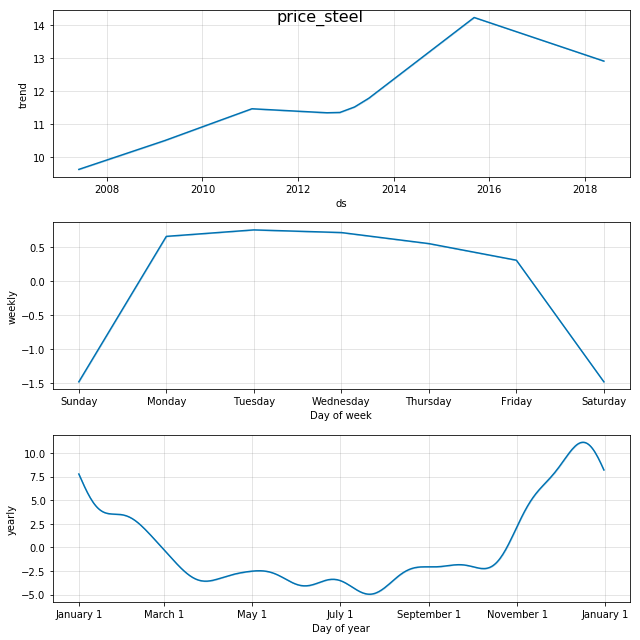

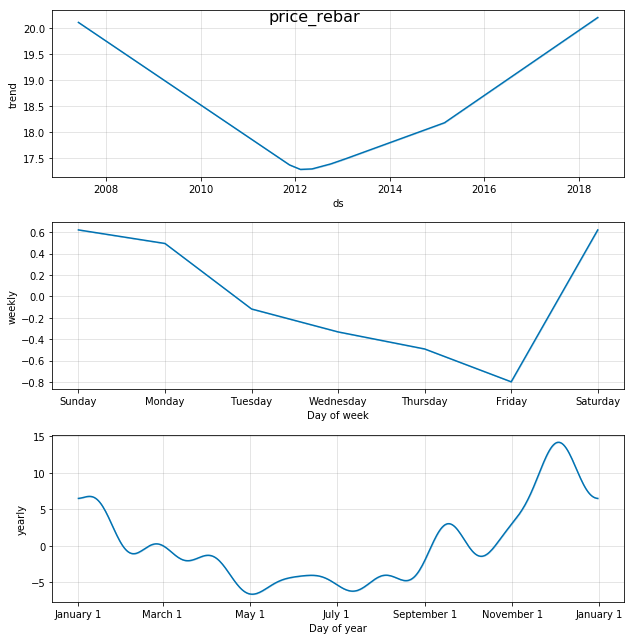

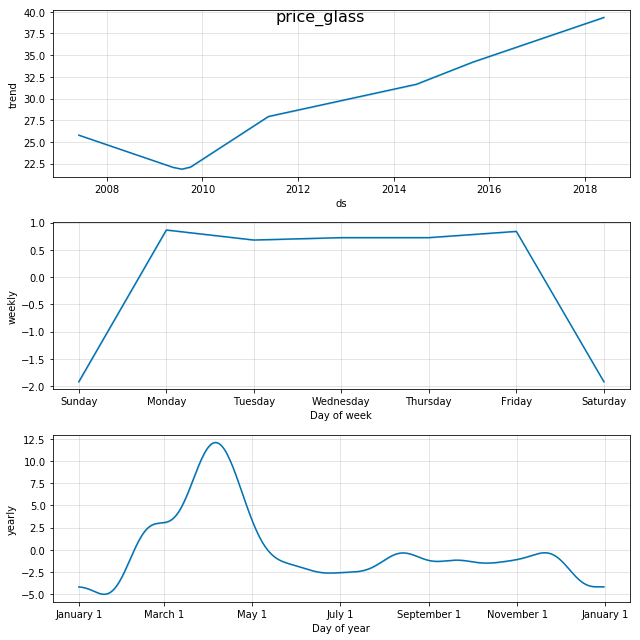

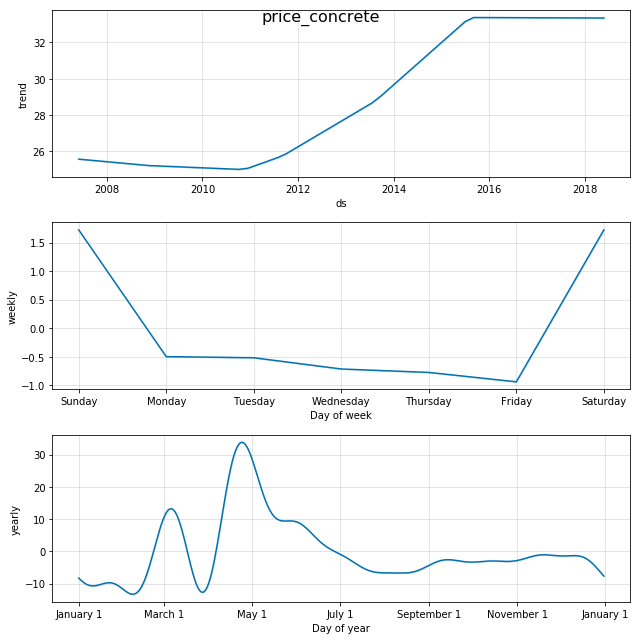

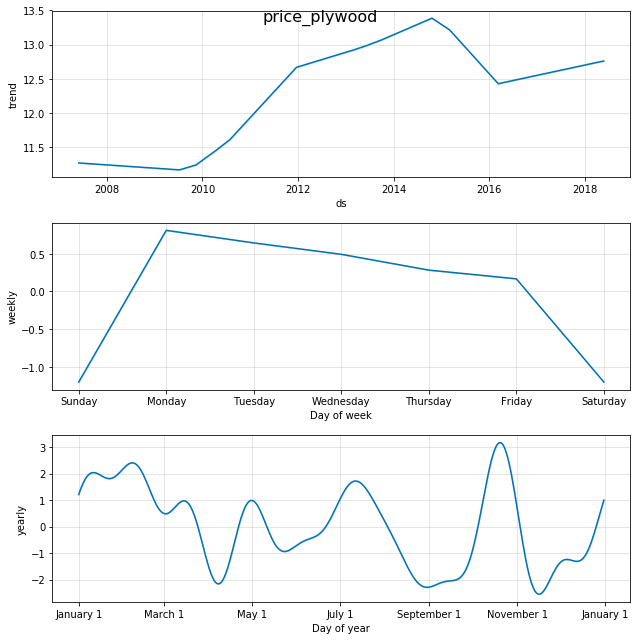

In [169]:
# I consider the latest 360 data as the test data set (almost 1 year)
prediction_size = 10

models =[None]*len(prices)
forecasts = [None]*len(prices)

for i in range(len(prices)):
    this_data = prices[i]
    train_df = this_data.sort_values(by=['ds'], ascending=True)[:-prediction_size]
    # Making a prophet model with its defaults
    m = Prophet()
    m.fit(train_df)
    
    future = m.make_future_dataframe(periods=prediction_size)
    forecast = m.predict(future)
    
    # Saving model and forecast for later use
    models[i] = m
    forecasts[i] = forecast
    
    #fig, axs = plt.subplots()
    fig = m.plot_components(forecast);
    fig.suptitle(titles[i], fontsize=16)
    plt.show()





The above diagrams gives more accuracy to the suggestions before. 

* Steel : Mid march till mid-July seems to be the best time for purchasing. The price has shown an steady increase since 2013. Compared to the declining price of plywood it is suggested to consider using more plywood frames than steel frames wherever possible.
* Rebar : Best time of year is from last week of March until the second week of July. For some reasons prices on Fridays are chipest therefore it is suggested that it will be bought on Fridays in the mentioned durations of the year. Its price has been also constantly increasing since 2012
* Glass : It's price has been also increasing since 2010. the best suggested buying period is Jun - Aug
* Concrete : Similar to glass. The only thing adding to add is that it is better if bought on Friday. Althought it may mean paying extra for the weekend work to the concrete workers to put it in place.
* Plywood: It has the most consistent time series data. Maybe because its storage is much easier and can be bought and stored all year round. Its price has also experienced a constant declie since 2015. The suggested time of the year for purchasing plywoods is last week of August until the third week in September


### Forecasting
Now we use the test data for checking if the models do well in forecasting


In [162]:
# helper function to join the forecast object with the actual values y from the original dataset df
# from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [163]:
# now apply the helper function to our data
cmp_df = [None]*len(prices)

for i in range(len(prices)):
    cmp_df[i] = make_comparison_dataframe(prices[i], forecasts[i])

In [164]:
# helper function that we will use to gauge the quality of our forecasting with MAPE and MAE error measures:
# from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [165]:
# now using the function to calculate forecast errors
for i in range(len(cmp_df)):
    for err_name, err_value in calculate_forecast_errors(cmp_df[i], prediction_size).items():
        print(titles[i], err_name, err_value)

price_steel MAPE 30.014693527494014
price_steel MAE 3.375844388941479
price_rebar MAPE 39.67196334410143
price_rebar MAE 6.034842163723575
price_glass MAPE 3.880460458291118
price_glass MAE 1.5109248114360136
price_concrete MAPE 14.43523560566352
price_concrete MAE 4.262540314281078
price_plywood MAPE 24.695665449717165
price_plywood MAE 3.9730533801279933


### Visulization
This part tries to show the accuracy of the forecast models on diagrams.


In [166]:
# helper function to show the forecast with lower and higher bounds and using plotly
# https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc

def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gold"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="green"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [167]:
for i in range(len(cmp_df)):
    show_forecast(cmp_df[i], prediction_size, 100, titles[i])